In [1]:
pip install torch torchvision torch-geometric

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 615.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.2/321.2 kB 13.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


emplearemos el conjunto de datos Cora, uno de los más populares en tareas de grafos, que contiene información de artículos científicos conectados por citas. Cada nodo representa un artículo, y las conexiones indican citaciones entre ello

Clasificación de gráficos : la utilizamos para clasificar gráficos en varias categorías. Sus aplicaciones son el análisis de redes sociales y la clasificación de texto. 

/tmp/ipykernel_4162145/4091695935.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


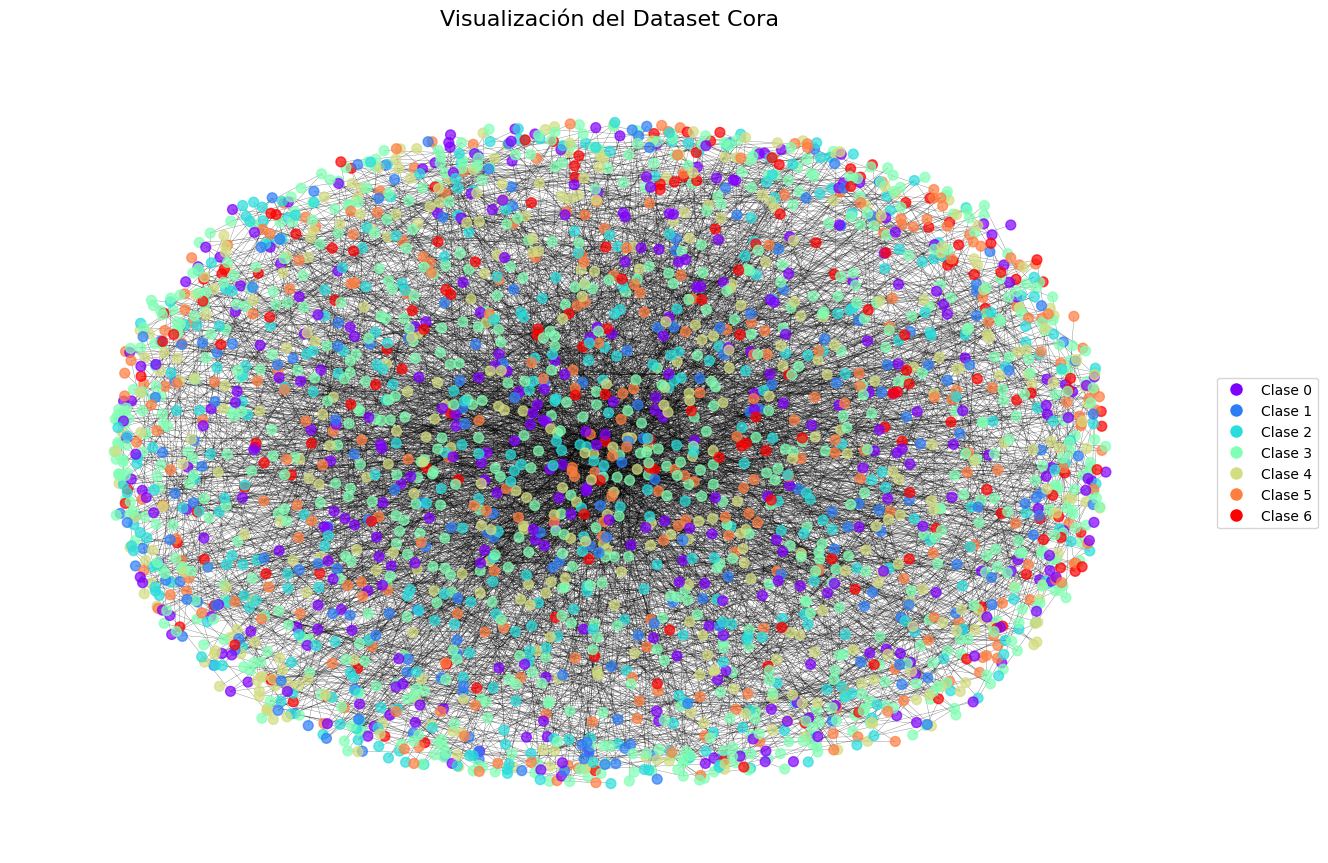


Información del grafo:
Número de nodos: 2708
Número de aristas: 5278
Número de clases: 7
Número de características por nodo: 1433


In [4]:
# Importar bibliotecas necesarias
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np

# Cargar el dataset Cora
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

# Convertir a NetworkX
def to_networkx(data):
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    
    # Añadir nodos
    for i in range(data.x.shape[0]):
        G.add_node(i)
    
    # Añadir aristas
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    
    return G

# Crear el grafo
G = to_networkx(data)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Obtener colores basados en las clases
colors = data.y.numpy()
unique_classes = len(torch.unique(data.y))
color_map = plt.cm.rainbow(np.linspace(0, 1, unique_classes))
node_colors = [color_map[c] for c in colors]

# Dibujar el grafo
pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw(G, 
        pos=pos,
        node_color=node_colors,
        node_size=50,
        width=0.2,
        alpha=0.7,
        with_labels=False)

# Añadir título y leyenda
plt.title('Visualización del Dataset Cora', fontsize=16, pad=20)

# Crear leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=color_map[i], label=f'Clase {i}',
                  markersize=10)
                  for i in range(unique_classes)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Imprimir información sobre el grafo
print(f"\nInformación del grafo:")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Número de clases: {unique_classes}")
print(f"Número de características por nodo: {data.x.shape[1]}")

Definición:
En un grafo, un nodo es un punto que representa una entidad o un objeto.

En el dataset Cora:
Cada nodo representa un artículo científico.

Definición: Las características son información descriptiva asociada a cada nodo. Son valores numéricos que resumen propiedades relevantes del nodo.

En el dataset Cora:
Cada nodo tiene una representación basada en un vector Bag-of-Words (BoW).

Aristas: Representan citas entre artículos.

Processing...
Done!


Dataset: Cora():
- Número de grafos: 1
- Número de características por nodo: 1433
- Número de clases: 7
Epoch 20, Loss: 0.2761
Epoch 40, Loss: 0.0587
Epoch 60, Loss: 0.0467
Epoch 80, Loss: 0.0458
Epoch 100, Loss: 0.0354
Epoch 120, Loss: 0.0357
Epoch 140, Loss: 0.0321
Epoch 160, Loss: 0.0303
Epoch 180, Loss: 0.0255
Epoch 200, Loss: 0.0215
Precisión en el conjunto de prueba: 0.7960


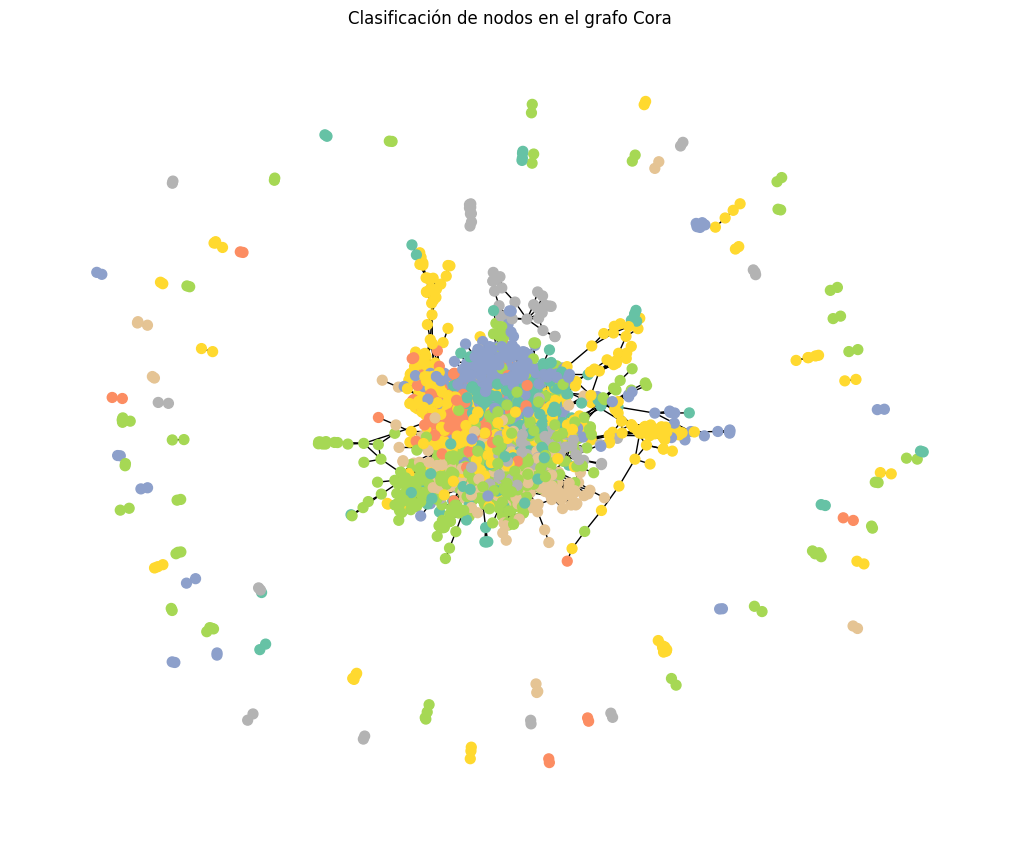

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Paso 1: Cargar el dataset Cora
dataset = Planetoid(root='data/Cora', name='Cora')

# Mostrar detalles del dataset
print(f"Dataset: {dataset}:")
print(f"- Número de grafos: {len(dataset)}")
print(f"- Número de características por nodo: {dataset.num_node_features}")
print(f"- Número de clases: {dataset.num_classes}")

# Usar el primer grafo del dataset
data = dataset[0]

# Paso 2: Definir la GNN
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)  #  # De 1433 -> 16 
        self.conv2 = GCNConv(16, dataset.num_classes)       # De 16 -> 7

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  #x: Características de los nodos (matriz de tamaño [num_nodos, 1433]). edge_index: Lista de bordes que conectan los nodos (matriz [2, num_aristas]).
        x = self.conv1(x, edge_index)  # Primera capa de convolución
        x = F.relu(x)                  # ReLU Función de activación no lineal.
        x = F.dropout(x, training=self.training)  # Regularización Evita sobreajuste apagando aleatoriamente conexiones durante el entrenamiento.
        x = self.conv2(x, edge_index)  # Segunda capa de convolución
        return F.log_softmax(x, dim=1)  # Probabilidades logarítmicas

# Paso 3: Entrenar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Entrenamiento
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Pérdida solo en nodos de entrenamiento
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Paso 4: Evaluar el modelo
model.eval()
_, pred = model(data).max(dim=1)  # Predicciones finales
correct = int((pred[data.test_mask] == data.y[data.test_mask]).sum())
accuracy = correct / int(data.test_mask.sum())
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

# Paso 5: Visualizar el grafo
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
G = to_networkx(data, to_undirected=True)
node_colors = pred.cpu().numpy()  # Colores según la predicción
nx.draw(G, node_size=50, node_color=node_colors, cmap='Set2')
plt.title("Clasificación de nodos en el grafo Cora")
plt.show()


In [11]:
#Incrustación de gráficos:  asigna gráficos a vectores, preservando la información relevante sobre nodos, bordes y estructura.
#MUTAG
#El dataset MUTAG contiene información sobre 188 compuestos químicos mutagénicos.

Información del Dataset MUTAG:
Número total de moléculas: 188
Número de clases: 2
Número de características de nodos: 7
Número de características de aristas: 4

Distribución de clases:
Clase 1: 125 moléculas
Clase 0: 63 moléculas

Estadísticas de tamaño de moléculas:
Promedio de átomos por molécula: 17.93
Mínimo de átomos: 10
Máximo de átomos: 28


Processing...
Done!


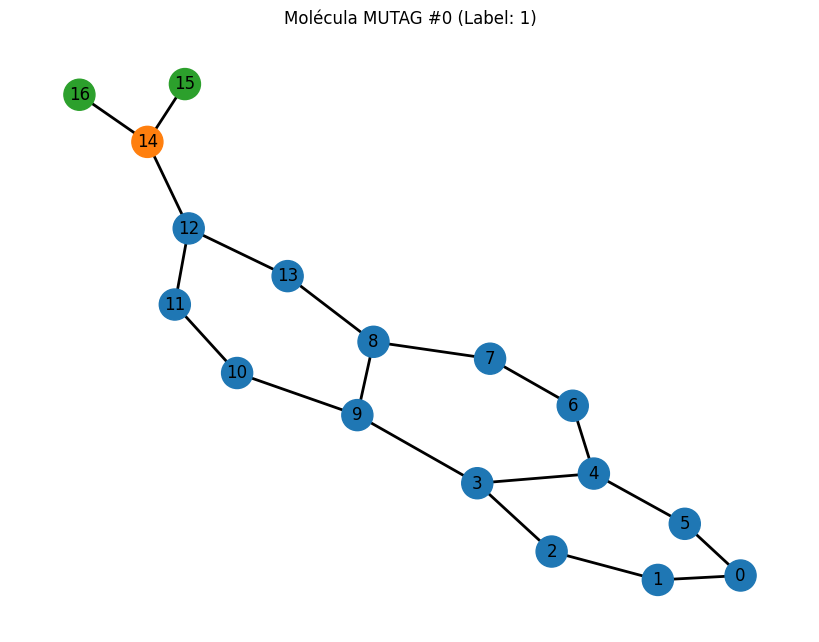

In [10]:
from torch_geometric.datasets import TUDataset
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import Counter

# Cargar el dataset MUTAG
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
data = dataset[0]  # Obtener el primer grafo como ejemplo

# Función para convertir a NetworkX
def to_networkx_with_edge_attrs(data):
    G = nx.Graph()
    
    # Añadir nodos con atributos
    for i in range(data.x.shape[0]):
        G.add_node(i, atom_type=data.x[i].argmax().item())  #Un nodo podría representar un átomo de carbono, hidrógeno, etc.
    
    # Añadir aristas con atributos
    edge_index = data.edge_index.numpy()  # Matriz que describe las conexiones entre nodos (pares de nodos conectados por aristas).
    edge_attr = data.edge_attr.numpy() #Matriz de atributos de las aristas. Cada fila representa el tipo de enlace químico (simple, doble, etc.).
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i], 
                  bond_type=edge_attr[i].argmax().item())
    return G

# Crear función para visualizar un grafo específico
def visualize_graph(data_index):
    molecule = dataset[data_index]
    G = to_networkx_with_edge_attrs(molecule)
    
    plt.figure(figsize=(8, 6))
    
    # Definir colores para diferentes tipos de átomos
    atom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    node_colors = [atom_colors[G.nodes[node]['atom_type']] for node in G.nodes()]
    
    # Dibujar el grafo
    pos = nx.spring_layout(G)
    nx.draw(G, pos, 
            node_color=node_colors,
            node_size=500,
            with_labels=True,
            width=2)
    
    plt.title(f'Molécula MUTAG #{data_index} (Label: {dataset[data_index].y.item()})')
    plt.show()

# Analizar el dataset completo
print("Información del Dataset MUTAG:")
print(f"Número total de moléculas: {len(dataset)}")
print(f"Número de clases: {dataset.num_classes}")
print(f"Número de características de nodos: {dataset.num_node_features}")
print(f"Número de características de aristas: {dataset.num_edge_features}")

# Analizar distribución de clases
labels = [data.y.item() for data in dataset]
class_distribution = Counter(labels)
print("\nDistribución de clases:")
for class_label, count in class_distribution.items():
    print(f"Clase {class_label}: {count} moléculas")

# Estadísticas de tamaño de grafos
sizes = [data.num_nodes for data in dataset]
print(f"\nEstadísticas de tamaño de moléculas:")
print(f"Promedio de átomos por molécula: {np.mean(sizes):.2f}")
print(f"Mínimo de átomos: {min(sizes)}")
print(f"Máximo de átomos: {max(sizes)}")

# Visualizar el primer grafo como ejemplo
visualize_graph(0)

Processing...
Done!


Época 1, Pérdida: 6.8536
Época 2, Pérdida: 3.6768
Época 3, Pérdida: 3.9352
Época 4, Pérdida: 3.8122
Época 5, Pérdida: 3.1044
Época 6, Pérdida: 3.0410
Época 7, Pérdida: 3.0060
Época 8, Pérdida: 2.9173
Época 9, Pérdida: 2.7957
Época 10, Pérdida: 2.8215
Época 11, Pérdida: 2.8383
Época 12, Pérdida: 2.7010
Época 13, Pérdida: 2.7373
Época 14, Pérdida: 2.7168
Época 15, Pérdida: 2.7403
Época 16, Pérdida: 2.6777
Época 17, Pérdida: 2.6594
Época 18, Pérdida: 2.6544
Época 19, Pérdida: 2.7934
Época 20, Pérdida: 2.5895


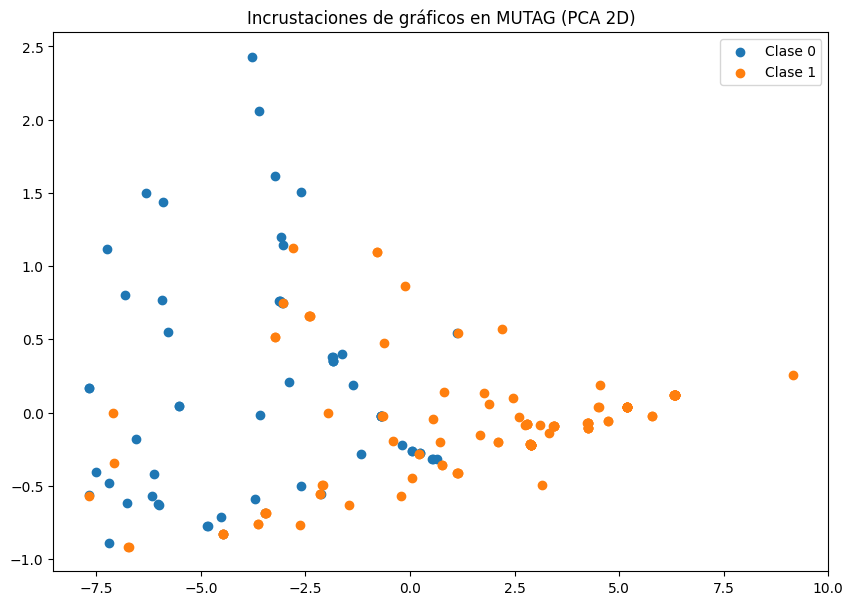

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, global_mean_pool
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar el conjunto de datos MUTAG
dataset = TUDataset(root=".", name="MUTAG")
loader = DataLoader(dataset, batch_size=32, shuffle=True)  #Divide el dataset en lotes de 32 grafos para entrenamiento y aleatorio por época.

# Definición del modelo de incrustación de gráficos
class GraphEmbeddingModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim) #convierte las características de entrada (átomos) en un espacio latente de dimensión hidden_dim.
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim) #capa conectada

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Agrega información de todos los nodos de cada grafo (batch) en una única representación fija (embedding del grafo).
        x = self.fc(x)  # Proyección a la dimensión final 
        return x

#x: Características de los nodos.
#edge_index: Conectividad de las aristas.
#batch: Indica a qué grafo pertenece cada nodo.

# Inicialización del modelo
input_dim = dataset.num_node_features
hidden_dim = 64
output_dim = 16  # Dimensión alta para incrustaciones
model = GraphEmbeddingModel(input_dim, hidden_dim, output_dim)

# Entrenamiento del modelo
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Ajusta los parámetros del modelo usando gradientes con una tasa de aprendizaje lr=0.01.
criterion = torch.nn.CrossEntropyLoss() #Función de pérdida (Calcula el error entre las predicciones (out) y las etiquetas reales (data.y).

for epoch in range(20):  # 20 épocas de entrenamiento
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to('cpu')  # Asegúrate de que los datos estén en CPU o GPU según corresponda
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)  # Forward
        loss = criterion(out, data.y)  # Tarea supervisada
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Época {epoch+1}, Pérdida: {total_loss:.4f}")

# Generar incrustaciones
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for data in loader:
        data = data.to('cpu')
        out = model(data.x, data.edge_index, data.batch)
        embeddings.append(out)
        labels.append(data.y)

embeddings = torch.cat(embeddings, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

# Reducción de dimensionalidad a 2D para visualización
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Visualización en 2D
plt.figure(figsize=(10, 7))
for label in set(labels):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Clase {label}')
plt.legend()
plt.title('Incrustaciones de gráficos en MUTAG (PCA 2D)')
plt.show()


In [12]:
#Generación de Graficos

Epoch 1, Loss: 0.1117
Epoch 2, Loss: 0.0404
Epoch 3, Loss: 0.0212
Epoch 4, Loss: 0.0076
Epoch 5, Loss: 0.0025
Epoch 6, Loss: 0.0026
Epoch 7, Loss: 0.0014
Epoch 8, Loss: 0.0007


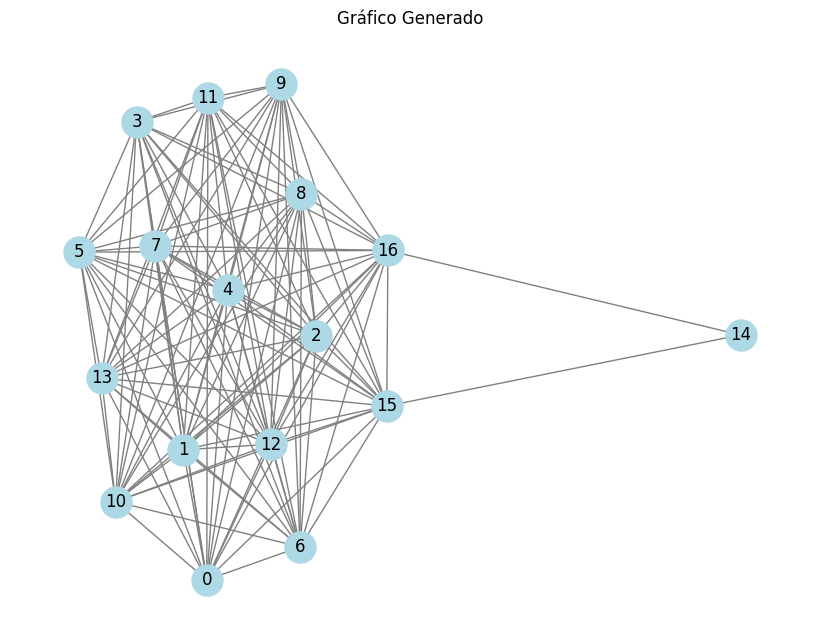

In [19]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import random

# ----------------------------
# 1. Cargar el conjunto de datos MUTAG
# ----------------------------
dataset = TUDataset(root='data/MUTAG', name='MUTAG')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ----------------------------
# 2. Definir el modelo generador
# ----------------------------
class GraphGenerator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphGenerator, self).__init__()
        self.encoder = torch.nn.Linear(in_channels, hidden_channels)  # Reduce la dimensión de entrada
        self.decoder = torch.nn.Linear(hidden_channels, out_channels)  # Predice la matriz de adyacencia y nodos
    
    def forward(self, x, edge_index, batch):
        # Codificar los nodos
        h = F.relu(self.encoder(x))
        # Decodificar para generar nuevos nodos y bordes
        generated_features = self.decoder(h)
        return generated_features

# ----------------------------
# 3. Configurar el modelo, optimizador y entrenamiento
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inicializar modelo
model = GraphGenerator(in_channels=dataset.num_node_features,
                       hidden_channels=32,
                       out_channels=dataset.num_node_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de entrenamiento
def train():
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        generated_features = model(data.x, data.edge_index, data.batch)
        loss = F.mse_loss(generated_features, data.x)  # Reconstruir características
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Entrenar el modelo
for epoch in range(8):
    loss = train()
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

# ----------------------------
# 4. Generar un gráfico nuevo
# ----------------------------
model.eval()
with torch.no_grad():
    # Seleccionar un gráfico base para generar uno nuevo
    example_graph = dataset[0].to(device)
    generated_features = model(example_graph.x, example_graph.edge_index, None)
    
    # Convertir a NetworkX para visualizar
    generated_graph = to_networkx(example_graph, to_undirected=True)
    new_graph = nx.Graph()
    
    # Generar bordes aleatoriamente
    for i in range(generated_features.size(0)):
        for j in range(i + 1, generated_features.size(0)):
            # Probabilidad de conexión basada en una función aleatoria (similaridad)
            prob = torch.sigmoid((generated_features[i] * generated_features[j]).sum()).item()
            if prob > 0.5:  # Umbral de conexión
                new_graph.add_edge(i, j)
    
    # Añadir nodos generados
    for i in range(generated_features.size(0)):
        new_graph.add_node(i)

# ----------------------------
# 5. Visualizar el gráfico generado
# ----------------------------
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(new_graph)
nx.draw(new_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Gráfico Generado")
plt.show()


In [20]:
#Karate

Número de nodos: 34, Número de aristas: 156
Época 1, Pérdida: 0.2485
Época 2, Pérdida: 0.2439
Época 3, Pérdida: 0.2389
Época 4, Pérdida: 0.2335
Época 5, Pérdida: 0.2275
Época 6, Pérdida: 0.2208
Época 7, Pérdida: 0.2133
Época 8, Pérdida: 0.2051
Época 9, Pérdida: 0.1962
Época 10, Pérdida: 0.1866
Época 11, Pérdida: 0.1763
Época 12, Pérdida: 0.1656
Época 13, Pérdida: 0.1545
Época 14, Pérdida: 0.1432
Época 15, Pérdida: 0.1318
Época 16, Pérdida: 0.1206
Época 17, Pérdida: 0.1096
Época 18, Pérdida: 0.0991
Época 19, Pérdida: 0.0892
Época 20, Pérdida: 0.0801
Época 21, Pérdida: 0.0717
Época 22, Pérdida: 0.0643
Época 23, Pérdida: 0.0579
Época 24, Pérdida: 0.0523
Época 25, Pérdida: 0.0476
Época 26, Pérdida: 0.0436
Época 27, Pérdida: 0.0404
Época 28, Pérdida: 0.0378
Época 29, Pérdida: 0.0357
Época 30, Pérdida: 0.0341
Época 31, Pérdida: 0.0328
Época 32, Pérdida: 0.0318
Época 33, Pérdida: 0.0310
Época 34, Pérdida: 0.0304
Época 35, Pérdida: 0.0299
Época 36, Pérdida: 0.0296
Época 37, Pérdida: 0.0293
Épo

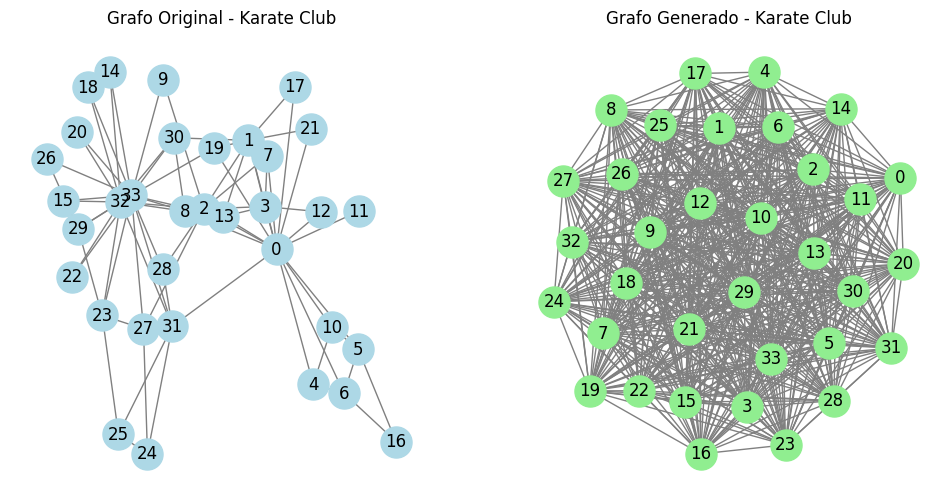

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx, dense_to_sparse
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import random

# ----------------------------
# 1. Cargar el dataset Karate Club
# ----------------------------
dataset = KarateClub()
data = dataset[0]  # Este dataset tiene un solo grafo
print(f"Número de nodos: {data.num_nodes}, Número de aristas: {data.num_edges}")

# ----------------------------
# 2. Definir el modelo generador
# ----------------------------
class GraphGenerator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GraphGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)  # Codificar características Aprende representaciones latentes (embeddings) de los nodos en el espacio gráfico.
        self.decoder = torch.nn.Linear(hidden_channels, in_channels)  # Decodificar Usa los embeddings generados para reconstruir las características originales de los nodos.
        
    def forward(self, x, edge_index):
        # Codificación
        h = F.relu(self.encoder(x, edge_index))
        # Decodificación
        reconstructed_x = torch.sigmoid(self.decoder(h))
        return reconstructed_x, h

# ----------------------------
# 3. Configuración del modelo
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphGenerator(in_channels=data.num_node_features, hidden_channels=16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ----------------------------
# 4. Entrenamiento del modelo Reconstruir las características originales de los nodos a partir de los embeddings generados.
# ----------------------------
def train():
    model.train()
    optimizer.zero_grad()
    reconstructed_x, _ = model(data.x, data.edge_index)
    loss = F.mse_loss(reconstructed_x, data.x)  # Reconstruir características Calcula el error cuadrático medio (MSE) entre las características originales (data.x) y las reconstruidas (reconstructed_x).
    loss.backward()
    optimizer.step()
    return loss.item()

# Entrenamiento por 50 épocas
for epoch in range(50):
    loss = train()
    print(f"Época {epoch+1}, Pérdida: {loss:.4f}")

# ----------------------------
# 5. Generar un nuevo grafo
# ----------------------------
model.eval()
with torch.no_grad():
    # Reconstruir características y codificaciones
    _, embeddings = model(data.x, data.edge_index)

    # Generar nuevos bordes aleatoriamente basados en embeddings
    new_edges = []
    for i in range(data.num_nodes):
        for j in range(i + 1, data.num_nodes):
            prob = torch.sigmoid((embeddings[i] * embeddings[j]).sum()).item() #La similitud se calcula como el producto punto entre los embeddings.
            if prob > 0.5:  # Umbral para conectar nodos
                new_edges.append((i, j))

# Crear un nuevo grafo con nodos y bordes generados
new_graph = nx.Graph()
new_graph.add_edges_from(new_edges)

# ----------------------------
# 6. Visualizar el grafo original y el generado
# ----------------------------
# Grafo original
original_graph = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(original_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Grafo Original - Karate Club")

# Grafo generado
plt.subplot(1, 2, 2)
pos = nx.spring_layout(new_graph)
nx.draw(new_graph, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
plt.title("Grafo Generado - Karate Club")
plt.show()


In [23]:
# Ejercicios dataset = Planetoid(root='data/CiteSeer', name='CiteSeer')  dataset = Planetoid(root='data/PubMed', name='PubMed')   dataset = Planetoid(root='data/Cora', name='Cora')

Número de nodos: 2708, Número de aristas: 10556
Número de características por nodo: 1433
Época 1, Pérdida: 0.2506
Época 2, Pérdida: 0.2412
Época 3, Pérdida: 0.2242
Época 4, Pérdida: 0.1985
Época 5, Pérdida: 0.1663
Época 6, Pérdida: 0.1307
Época 7, Pérdida: 0.0960
Época 8, Pérdida: 0.0664
Época 9, Pérdida: 0.0444
Época 10, Pérdida: 0.0301
Época 11, Pérdida: 0.0218
Época 12, Pérdida: 0.0174
Época 13, Pérdida: 0.0151
Época 14, Pérdida: 0.0140
Época 15, Pérdida: 0.0134
Época 16, Pérdida: 0.0130
Época 17, Pérdida: 0.0128
Época 18, Pérdida: 0.0127
Época 19, Pérdida: 0.0126
Época 20, Pérdida: 0.0126
Época 21, Pérdida: 0.0126
Época 22, Pérdida: 0.0125
Época 23, Pérdida: 0.0125
Época 24, Pérdida: 0.0125
Época 25, Pérdida: 0.0125
Época 26, Pérdida: 0.0125
Época 27, Pérdida: 0.0124
Época 28, Pérdida: 0.0124
Época 29, Pérdida: 0.0124
Época 30, Pérdida: 0.0124
Época 31, Pérdida: 0.0124
Época 32, Pérdida: 0.0124
Época 33, Pérdida: 0.0124
Época 34, Pérdida: 0.0124
Época 35, Pérdida: 0.0124
Época 36, 

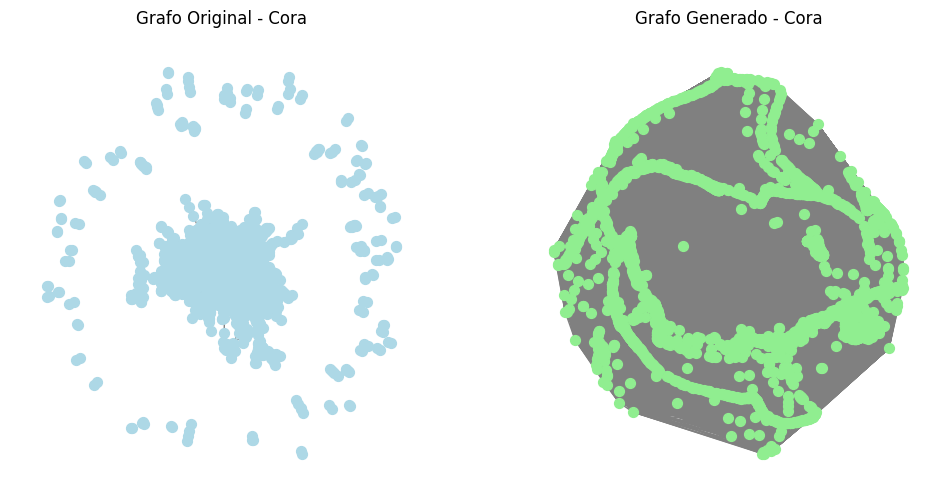

Processing...
Done!


Dataset: PubMed():
- Número de grafos: 1
- Número de características por nodo: 500
- Número de clases: 3
Epoch 20, Loss: 0.6977
Epoch 40, Loss: 0.3560
Epoch 60, Loss: 0.1760
Epoch 80, Loss: 0.1583
Epoch 100, Loss: 0.1237
Epoch 120, Loss: 0.0952
Epoch 140, Loss: 0.0950
Epoch 160, Loss: 0.1228
Epoch 180, Loss: 0.0868
Epoch 200, Loss: 0.0745
Precisión en el conjunto de prueba: 0.7770


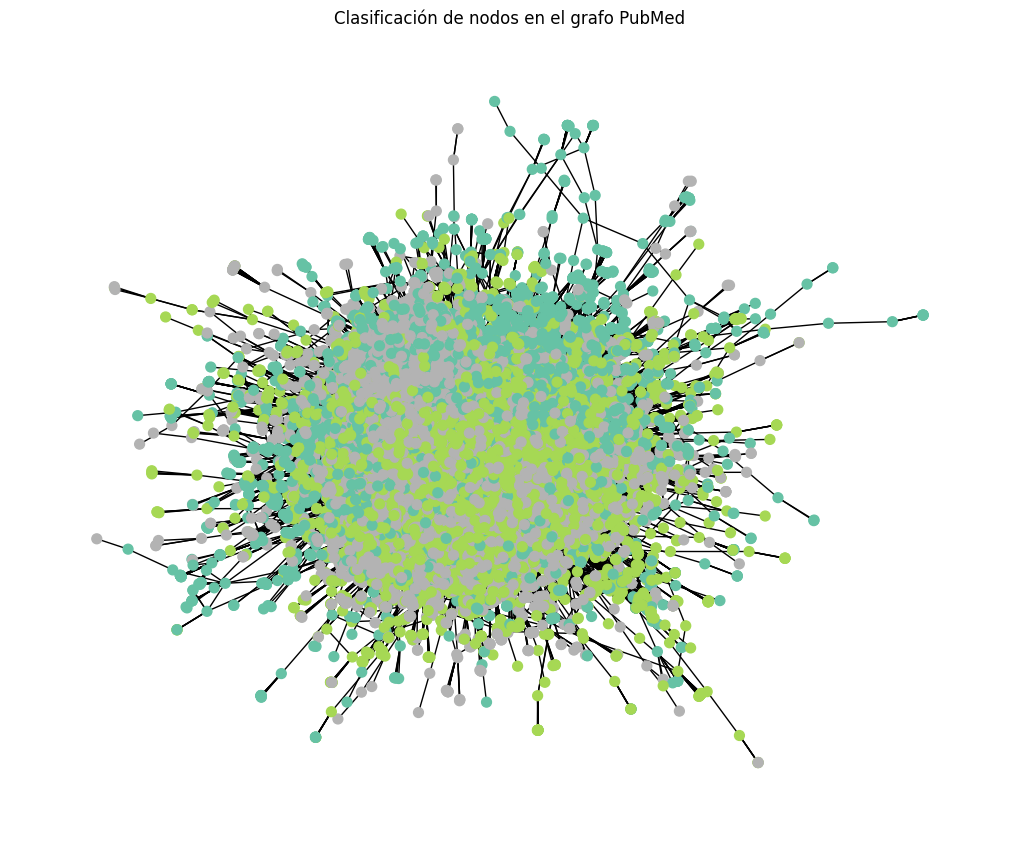

Processing...
Done!


Dataset: CiteSeer():
- Número de grafos: 1
- Número de características por nodo: 3703
- Número de clases: 6
Epoch 20, Loss: 0.1289
Epoch 40, Loss: 0.0685
Epoch 60, Loss: 0.0631
Epoch 80, Loss: 0.0510
Epoch 100, Loss: 0.0359
Epoch 120, Loss: 0.0270
Epoch 140, Loss: 0.0401
Epoch 160, Loss: 0.0236
Epoch 180, Loss: 0.0437
Epoch 200, Loss: 0.0319
Precisión en el conjunto de prueba: 0.6760


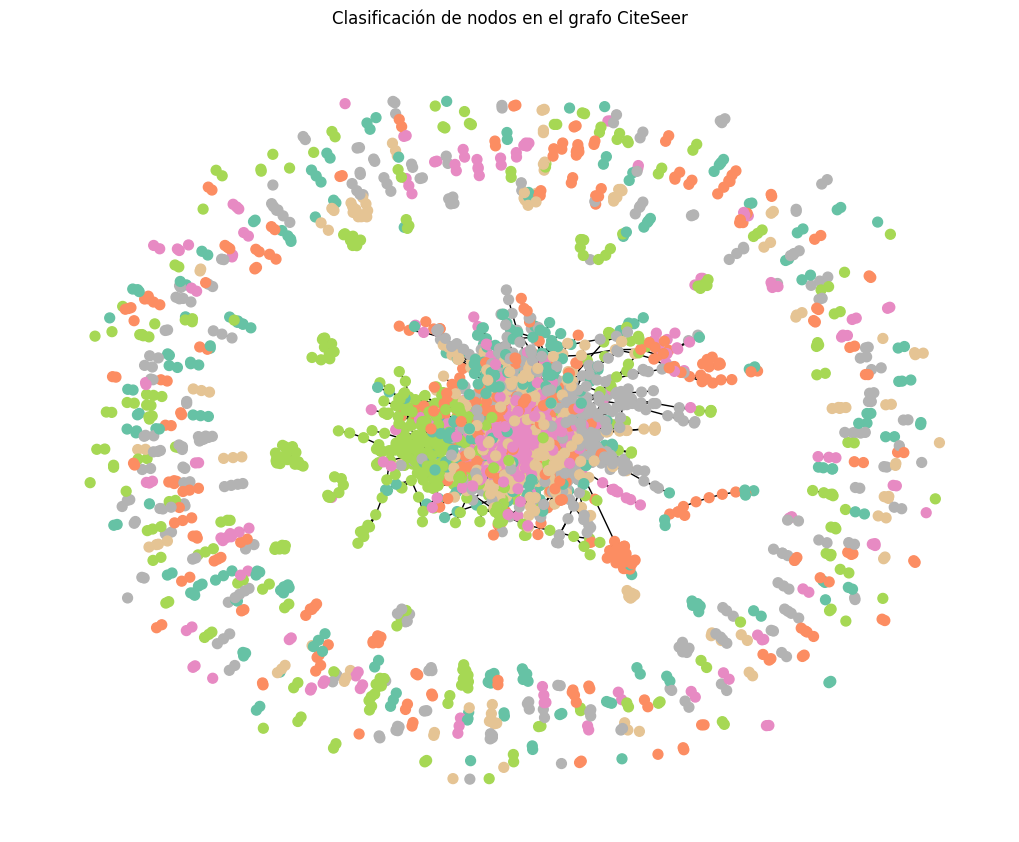